# INIT

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns

from tools_analysis import *

sns.set_theme()

In [14]:
folder_path = "../study"
stats_path = folder_path + "/stats"

In [15]:
# Reading the whole dataset
df = pd.read_csv("%s/dataset_thres1.csv" % stats_path, index_col="ID")
print(df.shape)
# # Removing the healty subjects
# df.dropna(axis=0, how="any", inplace=True) 
# print(df.shape)

info = df.columns[:10]
df[info] = df[info].astype(int)

df = df.drop("VNSLC_16") # remove it because doesn't have the tracts from freesurfer, if I comment it, all the TRACULA tracts will be removed
df = df.dropna(axis=1) # remove NaN features
df = df.drop(df.filter(regex=r'(min|max)'), axis=1) # remove max and min features because are full of imperfections
df = df.drop(df.filter(regex=r'(_c0_|_c1_|_f0_|_f1_|nTracts|voxVol)'), axis=1) # remove them beacuse they have an high variability and difficult to interpretare (only kurt)
df = df.loc[:, (abs(df - df.iloc[0]) > 1e-12).any()] # Removing almost constant features
print(df.shape)

X = df.drop(["resp", "respPart"], axis=1)
X = X.filter(regex=r'(mean|age|duration|sex)')
y = df["resp"]

(19, 7528)
(18, 5690)


# Logistic Regression

#### Scaling pruning

In [6]:
# Scaling pruning 

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, PowerTransformer
from sklearn.model_selection import StratifiedShuffleSplit

for scaler in [StandardScaler(), MinMaxScaler(), Normalizer("l1"), Normalizer("l2"), RobustScaler(unit_variance=True)]:
    print(scaler.__class__.__name__)
    
    run_log_reg_cv(
        X, 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=scaler,
        )

StandardScaler
F1: 0.733 | Pr: 0.813 | Re: 0.972 | AUC: 0.677 | Accuracy: 0.645 | B_Acc: 0.607 

MinMaxScaler
F1: 0.734 | Pr: 0.817 | Re: 0.971 | AUC: 0.683 | Accuracy: 0.648 | B_Acc: 0.612 

Normalizer
F1: 0.704 | Pr: 0.742 | Re: 0.990 | AUC: 0.470 | Accuracy: 0.581 | B_Acc: 0.502 

Normalizer
F1: 0.704 | Pr: 0.740 | Re: 0.990 | AUC: 0.468 | Accuracy: 0.580 | B_Acc: 0.499 

RobustScaler
F1: 0.715 | Pr: 0.799 | Re: 0.960 | AUC: 0.626 | Accuracy: 0.619 | B_Acc: 0.574 



#### Hyper parm pruning

In [7]:
# Hyper-parameters pruning
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

param_grid = {
    "logisticregression__C" : [1e0, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
}

pipe = make_pipeline(
    StandardScaler(), 
    LogisticRegression(
        penalty="l2",
        dual=True,
        class_weight="balanced",
        random_state=7,
        solver="liblinear",
        max_iter=100000,
    )
)

gridSearch = GridSearchCV(
    pipe,
    param_grid,
    scoring=make_scorer(auc_and_f1, needs_proba=True),
    n_jobs=-1,
    cv=StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
)

gridSearch.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1000, random_state=7,
            test_size=0.3333333333333333, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(class_weight='balanced',
                                                           dual=True,
                                                           max_iter=100000,
                                                           random_state=7,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [1.0, 0.5, 0.1, 0.05, 0.01,
                                                   0.005, 0.001, 0.0005, 0.0001,
                                                   5e-05, 1e-05, 5e-06,
                                                   1e-06]},
             scoring=make_scorer(auc_and_f1, needs_threshold=True))

In [9]:
print("f1 + auc score")
print(gridSearch.cv_results_["mean_test_score"])
print(gridSearch.cv_results_["std_test_score"])
print(gridSearch.cv_results_["rank_test_score"])

f1 + auc score
[1.40983929 1.41461905 1.42289286 1.42845833 1.45030357 1.47366071
 1.53922024 1.55289286 1.57513095 1.57920238 1.58270238 1.58303571
 1.5831369 ]
[0.23946018 0.23850379 0.23823477 0.24030733 0.24703508 0.25711849
 0.27213424 0.27689623 0.27964924 0.28004244 0.27986224 0.27980696
 0.27980648]
[13 12 11 10  9  8  7  6  5  4  3  2  1]


In [ ]:
"""
f1 + auc score
[1.40983929 1.41461905 1.42289286 1.42845833 1.45030357 1.47366071
 1.53922024 1.55289286 1.57513095 1.57920238 1.58270238 1.58303571
 1.5831369 ]
[0.23946018 0.23850379 0.23823477 0.24030733 0.24703508 0.25711849
 0.27213424 0.27689623 0.27964924 0.28004244 0.27986224 0.27980696
 0.27980648]
[13 12 11 10  9  8  7  6  5  4  3  2  1]
"""

#### Scalar pruning with best hyperparameter

In [8]:
# Scaling pruning with best hyperparameter

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, PowerTransformer
from sklearn.model_selection import StratifiedShuffleSplit

for scaler in [StandardScaler(), MinMaxScaler(), Normalizer("l1"), Normalizer("l2")]:
    print(scaler.__class__.__name__)
    
    run_log_reg_cv(
        X, 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=scaler,
        C=1e-6,
        )

StandardScaler
F1: 0.789 | Pr: 0.887 | Re: 0.991 | AUC: 0.794 | Accuracy: 0.730 | B_Acc: 0.724 

MinMaxScaler
F1: 0.784 | Pr: 0.879 | Re: 0.991 | AUC: 0.783 | Accuracy: 0.721 | B_Acc: 0.711 

Normalizer
F1: 0.704 | Pr: 0.741 | Re: 0.990 | AUC: 0.469 | Accuracy: 0.581 | B_Acc: 0.501 

Normalizer
F1: 0.704 | Pr: 0.742 | Re: 0.989 | AUC: 0.472 | Accuracy: 0.581 | B_Acc: 0.502 



#### Sequential Feature Selection

Here launch the feature selection in seqFeatureSelec.py with the tuned parameters.

Check the performance with the selected features

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

print("l2")
run_log_reg_cv(
        X[['cc.bodyt_frac_ctot_mean', 'right-fornix_RD_mean']], 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=StandardScaler(),
        C=1e-6,
)

l2
F1: 0.857 | Pr: 1.000 | Re: 1.000 | AUC: 1.000 | Accuracy: 0.833 | B_Acc: 0.875 



LogisticRegression(C=1e-06, class_weight='balanced', dual=True, max_iter=100000,
                   random_state=7, solver='liblinear')

#### Do again hyper parameter pruning with the selected features

In [16]:
# Hyper-parameters pruning
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

param_grid = {
    "logisticregression__C" : [1e0, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
}

pipe = make_pipeline(
    StandardScaler(), 
    LogisticRegression(
        dual=True,
        class_weight="balanced",
        random_state=7,
        solver="liblinear",
        max_iter=100000,
    )
)

gridSearch = GridSearchCV(
    pipe,
    param_grid,
    scoring=make_scorer(auc_and_f1, needs_proba=True),
    n_jobs=-1,
    cv=StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
)

gridSearch.fit(X[['epilepsy_type', 'acomm_fbundle_mean', 'acomm_fintra_mean', 'cc.bodyc_RD_mean', 'cc.bodypm_RD_mean', 'cc.bodyt_frac_csf_d_mean', 'cc.splenium_wFA_mean', 'left-amygdala_wFA_mean', 'left-hippocampus_AD_mean', 'right-fornix_RD_mean']], y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1000, random_state=7,
            test_size=0.3333333333333333, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(class_weight='balanced',
                                                           dual=True,
                                                           max_iter=100000,
                                                           random_state=7,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [1.0, 0.5, 0.1, 0.05, 0.01,
                                                   0.005, 0.001, 0.0005, 0.0001,
                                                   5e-05, 1e-05, 5e-06,
                                                   1e-06]},
             scoring=make_scorer(auc_and_f1, needs_proba=True))

In [17]:
print("f1 + auc score")
print(gridSearch.cv_results_["mean_test_score"])
print(gridSearch.cv_results_["std_test_score"])
print(gridSearch.cv_results_["rank_test_score"])

f1 + auc score
[1.71214881 1.73246429 1.76904167 1.77807738 1.78790476 1.7874881
 1.78888095 1.78888095 1.78888095 1.78888095 1.78888095 1.78888095
 1.78888095]
[0.19639268 0.18068071 0.14820107 0.13925276 0.13022969 0.13199144
 0.13149333 0.13149333 0.13149333 0.13149333 0.13149333 0.13149333
 0.13149333]
[13 12 11 10  8  9  1  1  1  1  1  1  1]


In [ ]:
"""
f1 + auc score
[1.78518452 1.78425    1.78307143 1.78319643 1.78317857 1.78309524
 1.78309524 1.78284524 1.78284524 1.78284524 1.78284524 1.78284524
 1.78284524]
[0.12884301 0.13117317 0.13153831 0.13156621 0.1319108  0.13250947
 0.13250947 0.13292477 0.13292477 0.13292477 0.13292477 0.13292477
 0.13292477]
[1 2 7 3 4 5 5 8 8 8 8 8 8]

f1 + auc score
[1.71214881 1.73246429 1.76904167 1.77807738 1.78790476 1.7874881
 1.78888095 1.78888095 1.78888095 1.78888095 1.78888095 1.78888095
 1.78888095]
[0.19639268 0.18068071 0.14820107 0.13925276 0.13022969 0.13199144
 0.13149333 0.13149333 0.13149333 0.13149333 0.13149333 0.13149333
 0.13149333]
[13 12 11 10  8  9  1  1  1  1  1  1  1]
"""

#### Display decision boundary

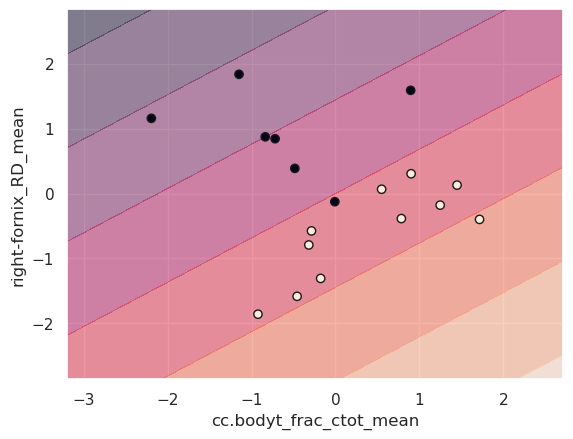

In [20]:
from sklearn.inspection import DecisionBoundaryDisplay

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['cc.bodyt_frac_ctot_mean', 'right-fornix_RD_mean']])

log_reg = LogisticRegression(
    penalty="l2",
    C=1e-6,
    dual=True,
    class_weight="balanced",
    random_state=7,
    solver="liblinear",
    max_iter=100000,
)

log_reg.fit(X_scaled, y)

disp = DecisionBoundaryDisplay.from_estimator(
    log_reg,
    X_scaled,
    response_method="predict_proba",
    xlabel='cc.bodyt_frac_ctot_mean',
    ylabel='right-fornix_RD_mean',
    alpha=0.5,
    plot_method="contourf"
)
disp.ax_.scatter(
    X_scaled[:, 0],
    X_scaled[:, 1],
    c=y,
    edgecolors="k"
)
plt.show()

#### Feature Weights

In [27]:
import eli5
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X[['epilepsy_type', 'acomm_fbundle_mean', 'acomm_fintra_mean', 'cc.bodyc_RD_mean', 'cc.bodypm_RD_mean', 'cc.bodyt_frac_csf_d_mean', 'cc.splenium_wFA_mean', 'left-amygdala_wFA_mean', 'left-hippocampus_AD_mean', 'right-fornix_RD_mean']],
    y,
    test_size=1/3,
    random_state=7,
    shuffle=True,
    stratify=y
)

pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        penalty="l2",
        C=1e-2,
        dual=True,
        class_weight="balanced",
        random_state=7,
        solver="liblinear",
        max_iter=100000,
    )
)

pipe.fit(X_train, y_train)

eli5.show_weights(pipe, feature_names=X_train.columns)

Weight?,Feature
+0.031,acomm_fintra_mean
+0.028,left-amygdala_wFA_mean
+0.008,cc.splenium_wFA_mean
+0.001,<BIAS>
-0.014,cc.bodyt_frac_csf_d_mean
-0.017,acomm_fbundle_mean
-0.019,cc.bodyc_RD_mean
-0.023,cc.bodypm_RD_mean
-0.027,epilepsy_type
-0.028,left-hippocampus_AD_mean


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


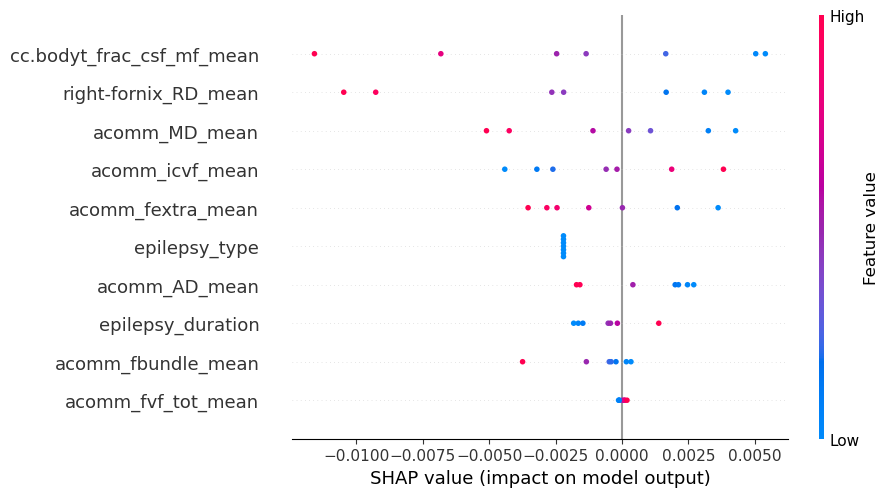

In [8]:
import shap
shap.initjs()
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    df[['epilepsy_type', 'epilepsy_duration', 'acomm_AD_mean', 'acomm_MD_mean', 'acomm_fbundle_mean', 'acomm_fextra_mean', 'acomm_fvf_tot_mean', 'acomm_icvf_mean', 'cc.bodyt_frac_csf_mf_mean', 'right-fornix_RD_mean']],
    df["resp"],
    test_size=1/3,
    random_state=7,
    shuffle=True,
    stratify=df["resp"]
)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

logReg = SGDClassifier(
    loss = 'log_loss',
    n_jobs = -1, 
    penalty = 'l2', 
    alpha=50,
    max_iter=10000
)

logReg.fit(X_train, y_train)

explainer = shap.Explainer(logReg, X_train, feature_names=df[['epilepsy_type', 'epilepsy_duration', 'acomm_AD_mean', 'acomm_MD_mean', 'acomm_fbundle_mean', 'acomm_fextra_mean', 'acomm_fvf_tot_mean', 'acomm_icvf_mean', 'cc.bodyt_frac_csf_mf_mean', 'right-fornix_RD_mean']].columns)
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values)#, X_test_array, feature_names=vectorizer.get_feature_names())

In [15]:
shap.plots.force(shap_values[0])

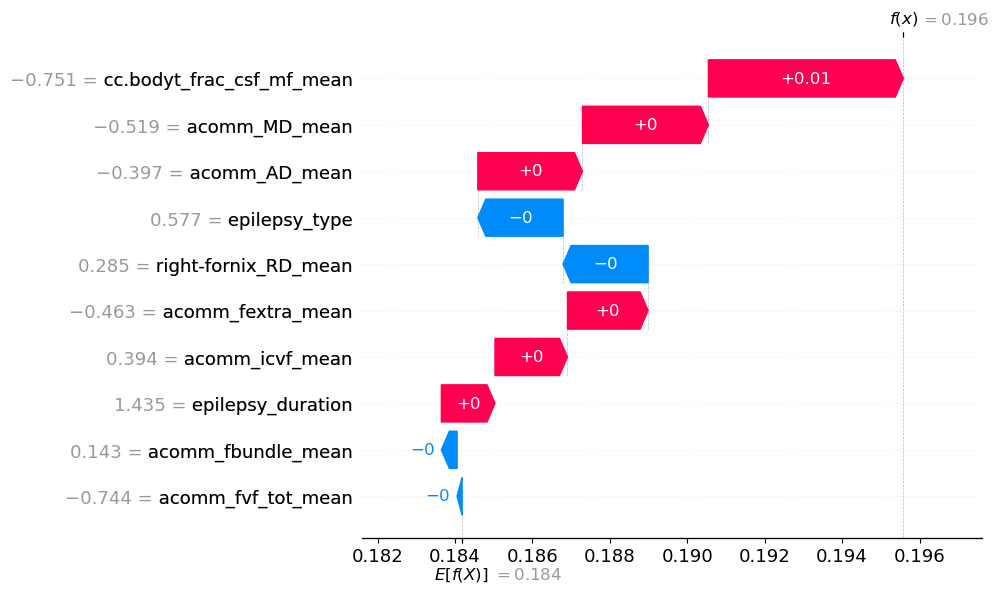

In [16]:
shap.plots.waterfall(shap_values[0])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


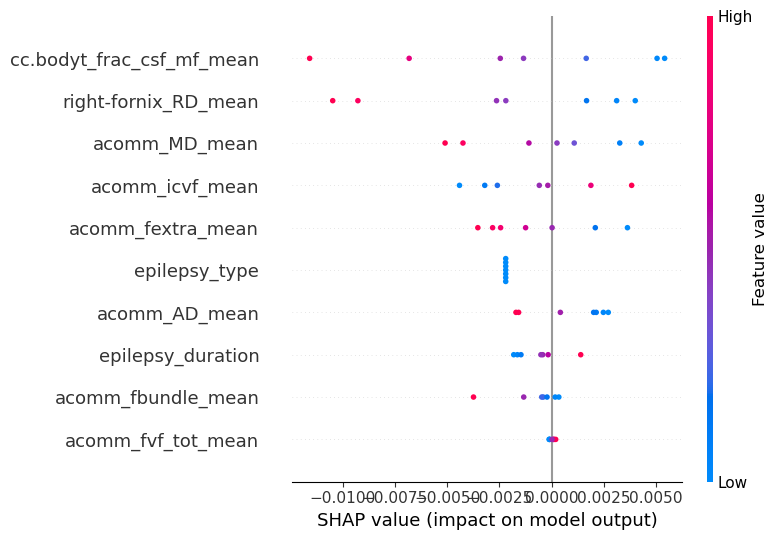

In [17]:
shap.summary_plot(shap_values, X_test)

#### Plots

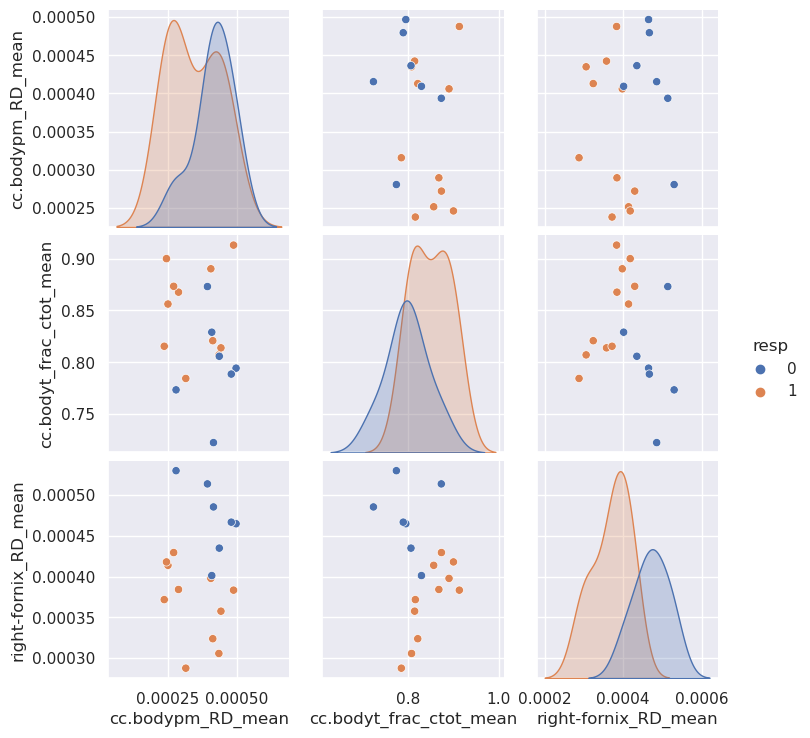

In [21]:
toPlot = ['cc.bodypm_RD_mean', 'cc.bodyt_frac_ctot_mean', 'right-fornix_RD_mean']
ax = sns.pairplot(df, hue="resp", x_vars=toPlot, y_vars=toPlot)

# SVM

#### Scaling pruning

In [4]:
# Scaling pruning 

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, PowerTransformer
from sklearn.model_selection import StratifiedShuffleSplit

for scaler in [StandardScaler(), MinMaxScaler(), Normalizer("l1"), Normalizer("l2"), RobustScaler(unit_variance=True)]:
    print(scaler.__class__.__name__)
    
    run_svm_cv(
        X, 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=scaler,
        )

StandardScaler
F1: 0.730 | Pr: 0.808 | Re: 0.972 | AUC: 0.662 | Accuracy: 0.640 

MinMaxScaler
F1: 0.726 | Pr: 0.802 | Re: 0.972 | AUC: 0.653 | Accuracy: 0.633 

Normalizer
F1: 0.704 | Pr: 0.740 | Re: 0.991 | AUC: 0.467 | Accuracy: 0.580 

Normalizer
F1: 0.703 | Pr: 0.739 | Re: 0.990 | AUC: 0.455 | Accuracy: 0.578 

RobustScaler


the best scaler is the MinMaxScaler(), but the results are very similat to StandardScaler, therefore we will use standardScaler to maintain the same scaler.

#### Hyper parm pruning

In [5]:
# Hyper-parameters pruning
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

param_grid = {
    "linearsvc__C" : [1e0, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
}

pipe = make_pipeline(
    StandardScaler(), 
    LinearSVC(
            dual=True,
            class_weight="balanced",
            random_state=7,
            max_iter=100000,
    )
)

gridSearch = GridSearchCV(
    pipe,
    param_grid,
    scoring=make_scorer(auc_and_f1, needs_threshold=True),
    n_jobs=-1,
    cv=StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
)

gridSearch.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1000, random_state=7,
            test_size=0.3333333333333333, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('linearsvc',
                                        LinearSVC(class_weight='balanced',
                                                  max_iter=100000,
                                                  random_state=7))]),
             n_jobs=-1,
             param_grid={'linearsvc__C': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005,
                                          0.001, 0.0005, 0.0001, 5e-05, 1e-05,
                                          5e-06, 1e-06]},
             scoring=make_scorer(auc_and_f1, needs_threshold=True))

In [6]:
print("f1 + auc score")
print(gridSearch.cv_results_["mean_test_score"])
print(gridSearch.cv_results_["std_test_score"])
print(gridSearch.cv_results_["rank_test_score"])

f1 + auc score
[1.39244048 1.39244048 1.39216667 1.39272619 1.39490476 1.40018452
 1.4293869  1.45845833 1.54131548 1.55792262 1.57655357 1.57997619
 1.58270238]
[0.2420911  0.2420911  0.24113025 0.24102171 0.23856038 0.23933262
 0.24153206 0.25138058 0.27258262 0.27745571 0.27956741 0.27946691
 0.27986224]
[11 11 13 10  9  8  7  6  5  4  3  2  1]


In [ ]:
"""
f1 + auc score
[1.39244048 1.39244048 1.39216667 1.39272619 1.39490476 1.40018452
 1.4293869  1.45845833 1.54131548 1.55792262 1.57655357 1.57997619
 1.58270238]
[0.2420911  0.2420911  0.24113025 0.24102171 0.23856038 0.23933262
 0.24153206 0.25138058 0.27258262 0.27745571 0.27956741 0.27946691
 0.27986224]
[11 11 13 10  9  8  7  6  5  4  3  2  1]
"""

In [21]:
# Scaling pruning with best hyperparameter

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, PowerTransformer
from sklearn.model_selection import StratifiedShuffleSplit

for scaler in [StandardScaler(), MinMaxScaler(), Normalizer("l1"), Normalizer("l2")]:
    print(scaler.__class__.__name__)
    
    run_svm_cv(
        X, 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=scaler,
        C=1e-6,
        penalty="l2"
        )

StandardScaler
F1: 0.789 | Pr: 0.887 | Re: 0.991 | AUC: 0.794 | Accuracy: 0.729 

MinMaxScaler
F1: 0.784 | Pr: 0.879 | Re: 0.991 | AUC: 0.783 | Accuracy: 0.721 

Normalizer
F1: 0.704 | Pr: 0.741 | Re: 0.990 | AUC: 0.469 | Accuracy: 0.581 

Normalizer
F1: 0.704 | Pr: 0.742 | Re: 0.989 | AUC: 0.472 | Accuracy: 0.581 



#### Sequential Feature Selection

Here launch the feature selection in seqFeatureSelec.py with the tuned parameters.

Check the performance with the selected features

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

print("l2")
run_svm_cv(
        X[['cc.bodyt_frac_ctot_mean', 'right-fornix_RD_mean']], 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=StandardScaler(),
        C=1e-6,
        penalty="l2"
        )

l2
F1: 0.857 | Pr: 1.000 | Re: 1.000 | AUC: 1.000 | Accuracy: 0.833 



LinearSVC(C=1e-06, class_weight='balanced', max_iter=100000, random_state=7)

#### Do again hyper parameter pruning with the selected features

In [35]:
# Hyper-parameters pruning

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline

param_grid = {
    "linearsvc__C" : [1e0, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
}

pipe = make_pipeline(
    StandardScaler(), 
    LinearSVC(
            penalty="l2",
            loss="hinge",
            dual=True,
            class_weight="balanced",
            random_state=7,
            max_iter=100000,
    )
)

gridSearch = GridSearchCV(
    pipe,
    param_grid,
    scoring=make_scorer(auc_and_f1, needs_threshold=True),
    n_jobs=-1,
    cv=StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
)

gridSearch.fit(X[['cc.bodyt_frac_csf_d_mean', 'right-fornix_RD_mean']], y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1000, random_state=7,
            test_size=0.3333333333333333, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('linearsvc',
                                        LinearSVC(class_weight='balanced',
                                                  loss='hinge', max_iter=100000,
                                                  random_state=7))]),
             n_jobs=-1,
             param_grid={'linearsvc__C': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005,
                                          0.001, 0.0005, 0.0001, 5e-05, 1e-05,
                                          5e-06, 1e-06]},
             scoring=make_scorer(auc_and_f1, needs_threshold=True))

In [36]:
print("f1 + auc score")
print(gridSearch.cv_results_["mean_test_score"])
print(gridSearch.cv_results_["std_test_score"])
print(gridSearch.cv_results_["rank_test_score"])

f1 + auc score
[1.7564881  1.75491667 1.76114881 1.75957143 1.75315476 1.75315476
 1.75315476 1.75315476 1.75315476 1.75315476 1.75315476 1.75315476
 1.75315476]
[0.16181413 0.16339689 0.15796489 0.15824361 0.165381   0.165381
 0.165381   0.165381   0.165381   0.165381   0.165381   0.165381
 0.165381  ]
[3 4 1 2 5 5 5 5 5 5 5 5 5]


#### Display decision boundary

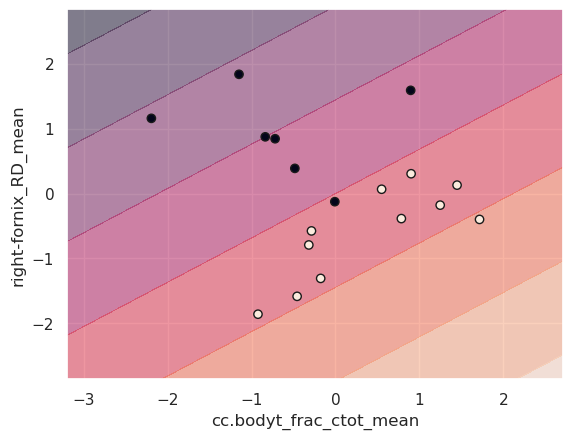

In [23]:
from sklearn.inspection import DecisionBoundaryDisplay

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['cc.bodyt_frac_ctot_mean', 'right-fornix_RD_mean']])

svm = LinearSVC(
    penalty="l2",
    loss="hinge",
    dual=True,
    C = 1e-6,
    class_weight="balanced",
    random_state=7,
    max_iter=100000,
)

svm.fit(X_scaled, y)

disp = DecisionBoundaryDisplay.from_estimator(
    svm,
    X_scaled,
    response_method="decision_function",
    xlabel='cc.bodyt_frac_ctot_mean',
    ylabel='right-fornix_RD_mean',
    alpha=0.5,
    plot_method="contourf"
)
disp.ax_.scatter(
    X_scaled[:, 0],
    X_scaled[:, 1],
    c=y,
    edgecolors="k"
)
plt.show()

# SVM kernel

#### Scaling pruning

In [4]:
# Scaling pruning 
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, PowerTransformer
from sklearn.model_selection import StratifiedShuffleSplit

for scaler in [StandardScaler(), MinMaxScaler(), Normalizer("l1"), Normalizer("l2")]:
    print(scaler.__class__.__name__)
    print("Linear")
    run_svm_kernel_cv(
        X, 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=scaler,
        kernel="linear"
    )
    print("Poly")
    for degree in [1, 2, 3]:
        print("Degree: ", degree)
        run_svm_kernel_cv(
            X, 
            y,
            StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
            pipeline=scaler,
            kernel = "poly",
            degree=degree,
        )
    print("RBF")
    run_svm_kernel_cv(
        X, 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=scaler,
    )

StandardScaler
Linear
F1: 0.723 | Pr: 0.799 | Re: 0.970 | AUC: 0.643 | Accuracy: 0.628 

Poly
Degree:  1
F1: 0.778 | Pr: 0.876 | Re: 0.985 | AUC: 0.787 | Accuracy: 0.714 

Degree:  2
F1: 0.703 | Pr: 0.760 | Re: 0.975 | AUC: 0.548 | Accuracy: 0.588 

Degree:  3
F1: 0.742 | Pr: 0.815 | Re: 0.983 | AUC: 0.684 | Accuracy: 0.652 

RBF
F1: 0.738 | Pr: 0.813 | Re: 0.980 | AUC: 0.661 | Accuracy: 0.647 

MinMaxScaler
Linear
F1: 0.725 | Pr: 0.802 | Re: 0.971 | AUC: 0.651 | Accuracy: 0.632 

Poly
Degree:  1
F1: 0.781 | Pr: 0.878 | Re: 0.987 | AUC: 0.796 | Accuracy: 0.717 

Degree:  2
F1: 0.728 | Pr: 0.817 | Re: 0.964 | AUC: 0.667 | Accuracy: 0.642 

Degree:  3
F1: 0.730 | Pr: 0.823 | Re: 0.962 | AUC: 0.671 | Accuracy: 0.645 

RBF
F1: 0.743 | Pr: 0.817 | Re: 0.983 | AUC: 0.675 | Accuracy: 0.653 

Normalizer
Linear
F1: 0.704 | Pr: 0.741 | Re: 0.990 | AUC: 0.469 | Accuracy: 0.581 

Poly
Degree:  1
F1: 0.704 | Pr: 0.741 | Re: 0.990 | AUC: 0.469 | Accuracy: 0.581 

Degree:  2
F1: 0.705 | Pr: 0.740 | R

#### Hyper param tuning

In [9]:
# Hyper-parameters pruning
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

param_grid = {
    "svc__C" : [1e0, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6],
}

pipe = make_pipeline(
    StandardScaler(), 
    SVC(
        kernel="poly",
        degree=1,
        class_weight="balanced",
        max_iter=-1,
        random_state=7
    )
)

gridSearch = GridSearchCV(
    pipe,
    param_grid,
    scoring=make_scorer(auc_and_f1, needs_threshold=True),
    n_jobs=-1,
    cv=StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
)

gridSearch.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1000, random_state=7,
            test_size=0.3333333333333333, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc',
                                        SVC(class_weight='balanced', degree=1,
                                            kernel='poly', random_state=7))]),
             n_jobs=-1,
             param_grid={'svc__C': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001,
                                    0.0005, 0.0001, 5e-05, 1e-05, 5e-06,
                                    1e-06]},
             scoring=make_scorer(auc_and_f1, needs_threshold=True))

In [10]:
print("f1 + auc score")
print(gridSearch.cv_results_["mean_test_score"])
print(gridSearch.cv_results_["std_test_score"])
print(gridSearch.cv_results_["rank_test_score"])

f1 + auc score
[1.56505952 1.57284524 1.58290476 1.58290476 1.58290476 1.58290476
 1.58290476 1.58290476 1.58290476 1.58290476 1.58290476 1.58290476
 1.58290476]
[0.26385859 0.27565022 0.27967532 0.27967532 0.27967532 0.27967532
 0.27967532 0.27967532 0.27967532 0.27967532 0.27967532 0.27967532
 0.27967532]
[13 12  1  1  1  1  1  1  1  1  1  1  1]


In [ ]:
"""
f1 + auc score
[1.56505952 1.57284524 1.58290476 1.58290476 1.58290476 1.58290476
 1.58290476 1.58290476 1.58290476 1.58290476 1.58290476 1.58290476
 1.58290476]
[0.26385859 0.27565022 0.27967532 0.27967532 0.27967532 0.27967532
 0.27967532 0.27967532 0.27967532 0.27967532 0.27967532 0.27967532
 0.27967532]
[13 12  1  1  1  1  1  1  1  1  1  1  1]
"""

In [4]:
# Hyper-parameters pruning
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

param_grid = {
    "svc__C" : [1e0, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6],
    "svc__gamma" : [1e0, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
}

pipe = make_pipeline(
    StandardScaler(), 
    SVC(
        kernel="rbf",
        class_weight="balanced",
        max_iter=-1,
        random_state=7
    )
)

gridSearch = GridSearchCV(
    pipe,
    param_grid,
    scoring=make_scorer(auc_and_f1, needs_threshold=True),
    n_jobs=-1,
    cv=StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
)

gridSearch.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1000, random_state=7,
            test_size=0.3333333333333333, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc',
                                        SVC(class_weight='balanced',
                                            random_state=7))]),
             n_jobs=-1,
             param_grid={'svc__C': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001,
                                    0.0005, 0.0001, 5e-05, 1e-05, 5e-06,
                                    1e-06],
                         'svc__gamma': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001,
                                        0.0005, 0.0001, 5e-05, 1e-05, 5e-06,
                                        1e-06]},
             scoring=make_scorer(auc_and_f1, needs_threshold=True))

In [5]:
print("f1 + auc score")
print(gridSearch.cv_results_["mean_test_score"])
print(gridSearch.cv_results_["std_test_score"])
print(gridSearch.cv_results_["rank_test_score"])

f1 + auc score
[0.5        0.5        0.5        0.5        1.13466429 1.22435119
 1.3571369  1.4042381  1.52373214 1.55036905 1.57606548 1.57841071
 1.58189881 0.5        0.5        0.5        0.5        1.13299167
 1.22255952 1.35470238 1.39839286 1.52373214 1.55036905 1.57606548
 1.57841071 1.58189881 0.5        0.5        0.5        0.5
 1.1286381  1.21776607 1.35470238 1.39839286 1.52373214 1.55036905
 1.57606548 1.57841071 1.58189881 0.5        0.5        0.5
 0.5        1.1279625  1.21699167 1.35470238 1.39839286 1.52373214
 1.55036905 1.57606548 1.57841071 1.58189881 0.5        0.5
 0.5        0.5        1.12464345 1.21415357 1.35470238 1.39839286
 1.52373214 1.55036905 1.57606548 1.57841071 1.58189881 0.5
 0.5        0.5        0.5        1.12141726 1.21270774 1.35470238
 1.39839286 1.52373214 1.55036905 1.57606548 1.57841071 1.58189881
 0.5        0.5        0.5        0.5        1.10901548 1.20870893
 1.35470238 1.39839286 1.52373214 1.55036905 1.57606548 1.57841071
 1.58189

#### Sequential Feature Selection

Here launch the feature selection in seqFeatureSelec.py with the tuned parameters.

check the performance with the selected feature

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

run_svm_kernel_cv(
        X[['right-pallidum_RD_mean', 'right-fornix_RD_mean', 'rh.slf1_MD_mean']], 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=StandardScaler(),
        kernel="rbf",
        degree=0,
        C=1,
        gamma=1e-6
    )

F1: 0.851 | Pr: 0.989 | Re: 0.999 | AUC: 0.992 | Accuracy: 0.824 



SVC(C=1, class_weight='balanced', degree=0, gamma=1e-06, random_state=7)

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

run_svm_kernel_cv(
        X[['rh.slf1_MD_mean', 'right-fornix_RD_mean', 'right-pallidum_RD_mean']], 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=StandardScaler(),
        kernel="poly",
        degree=1,
        C=0.1,
        gamma="scale"
    )

F1: 0.853 | Pr: 0.994 | Re: 0.999 | AUC: 0.995 | Accuracy: 0.828 



SVC(C=0.1, class_weight='balanced', degree=1, kernel='poly', random_state=7)

#### Do again hyper parameter pruning with the selected features

In [ ]:
# Hyper-parameters pruning
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

param_grid = {
    "svc__C" : [1e0, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6],
    "svc__gamma" : [1e0, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
}

pipe = make_pipeline(
    StandardScaler(), 
    SVC(
        kernel="rbf",
        class_weight="balanced",
        max_iter=-1,
        random_state=7
    )
)

gridSearch = GridSearchCV(
    pipe,
    param_grid,
    scoring=make_scorer(auc_and_f1, needs_threshold=True),
    n_jobs=-1,
    cv=StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
)

gridSearch.fit(X[['right-fornix_RD_mean', 'right-pallidum_RD_mean']], y)

#### Display decision boundary

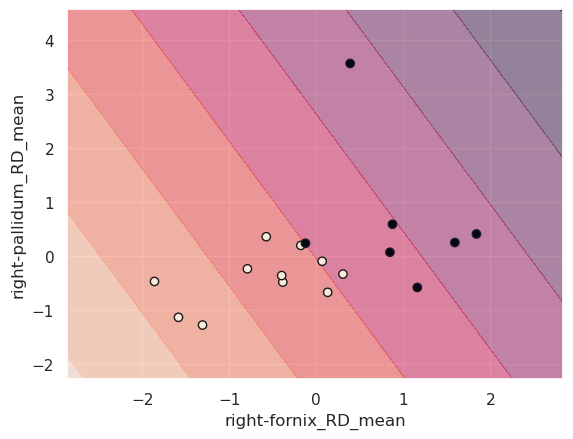

In [29]:
from sklearn.inspection import DecisionBoundaryDisplay

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['right-fornix_RD_mean', 'right-pallidum_RD_mean']])

svc = SVC(
    C = 0.1,
    kernel="poly",
    degree = 1,
    gamma = "scale",
    class_weight="balanced",
    max_iter=-1,
    random_state=7
)

svc.fit(X_scaled, y)

disp = DecisionBoundaryDisplay.from_estimator(
    svc,
    X_scaled,
    response_method="decision_function",
    xlabel='right-fornix_RD_mean',
    ylabel='right-pallidum_RD_mean',
    alpha=0.5,
    plot_method="contourf"
)
disp.ax_.scatter(
    X_scaled[:, 0],
    X_scaled[:, 1],
    c=y,
    edgecolors="k"
)
plt.show()

#### Plots

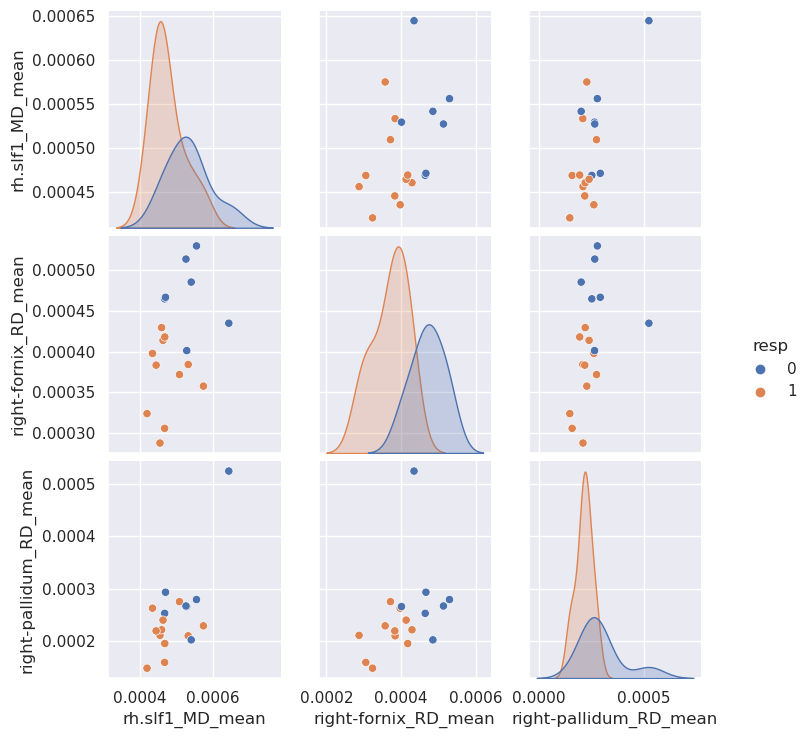

In [30]:
toPlot = ['rh.slf1_MD_mean', 'right-fornix_RD_mean', 'right-pallidum_RD_mean']
ax = sns.pairplot(df, hue="resp", x_vars=toPlot, y_vars=toPlot)

# Gaussian Naive Bayes

#### Scaling pruning

In [4]:
# Scaling pruning 
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, PowerTransformer
from sklearn.model_selection import StratifiedShuffleSplit

for scaler in [StandardScaler(), MinMaxScaler(), Normalizer("l1"), Normalizer("l2")]:
    print(scaler.__class__.__name__)
    
    run_gaussian_cv(
        X, 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=scaler,
        )

StandardScaler
F1: 0.257 | Pr: 0.740 | Re: 0.991 | AUC: 0.590 | Accuracy: 0.414 

MinMaxScaler
F1: 0.260 | Pr: 0.740 | Re: 0.991 | AUC: 0.591 | Accuracy: 0.415 

Normalizer
F1: 0.579 | Pr: 0.717 | Re: 0.997 | AUC: 0.480 | Accuracy: 0.518 

Normalizer
F1: 0.593 | Pr: 0.702 | Re: 0.999 | AUC: 0.425 | Accuracy: 0.511 



#### Sequential Feature Selection

Here launch the feature selection in seqFeatureSelec.py with the tuned parameters.

Check the performance with the selected features

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

run_gaussian_cv(
        X[['left-hippocampus_icvf_mean', 'rh.slf3_frac_ftot_mean']], 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=StandardScaler(),
        )

F1: 0.824 | Pr: 0.989 | Re: 0.997 | AUC: 0.989 | Accuracy: 0.808 



GaussianNB()

#### Display decision boundary

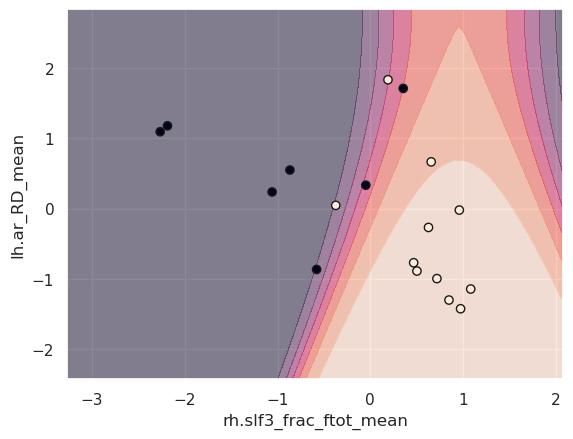

In [38]:
from sklearn.inspection import DecisionBoundaryDisplay

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['rh.slf3_frac_ftot_mean', 'lh.ar_RD_mean']])

gauss = GaussianNB()

gauss.fit(X_scaled, y)

disp = DecisionBoundaryDisplay.from_estimator(
    gauss,
    X_scaled,
    response_method="predict_proba",
    xlabel='rh.slf3_frac_ftot_mean',
    ylabel='lh.ar_RD_mean',
    alpha=0.5,
    plot_method="contourf"
)
disp.ax_.scatter(
    X_scaled[:, 0],
    X_scaled[:, 1],
    c=y,
    edgecolors="k"
)
plt.show()

# KNN

#### Scaling pruning

In [5]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, PowerTransformer
from sklearn.model_selection import StratifiedShuffleSplit

for scaler in [StandardScaler(), MinMaxScaler(), Normalizer("l1"), Normalizer("l2")]:
    print(scaler.__class__.__name__)
    
    run_knn_cv(
        X, 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=scaler,
        )

StandardScaler
F1: 0.758 | Pr: 0.862 | Re: 0.972 | AUC: 0.772 | Accuracy: 0.692 

MinMaxScaler
F1: 0.760 | Pr: 0.862 | Re: 0.971 | AUC: 0.782 | Accuracy: 0.695 

Normalizer
F1: 0.705 | Pr: 0.752 | Re: 0.991 | AUC: 0.571 | Accuracy: 0.591 

Normalizer
F1: 0.706 | Pr: 0.754 | Re: 0.990 | AUC: 0.575 | Accuracy: 0.593 



#### Hyper param tuning

In [11]:
# Hyper-parameters pruning
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

param_grid = {
    "kneighborsclassifier__n_neighbors" : [1, 2, 3, 4, 5, 6],
    "kneighborsclassifier__weights" : ["distance", "uniform"]
}

pipe = make_pipeline(
    StandardScaler(), 
    KNeighborsClassifier(
        n_jobs=-1
    )
)

gridSearch = GridSearchCV(
    pipe,
    param_grid,
    scoring=make_scorer(auc_and_f1, needs_proba=True),
    n_jobs=-1,
    cv=StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
)

gridSearch.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1000, random_state=7,
            test_size=0.3333333333333333, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_jobs=-1,
                                                             n_neighbors=3,
                                                             weights='distance'))]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': [1, 2, 3, 4, 5,
                                                               6],
                         'kneighborsclassifier__weights': ['distance',
                                                           'uniform']},
             scoring=make_scorer(auc_and_f1, needs_proba=True))

In [12]:
print("f1 + auc score")
print(gridSearch.cv_results_["mean_test_score"])
print(gridSearch.cv_results_["std_test_score"])
print(gridSearch.cv_results_["rank_test_score"])

f1 + auc score
[1.03630833 1.03630833 1.36572083 1.23504107 1.53025595 1.23648274
 1.54391964 1.29336667 1.52290476 1.24769702 1.45764881 1.1618506 ]
[0.30773881 0.30773881 0.28631676 0.27253168 0.27761423 0.26961853
 0.26410151 0.27178863 0.2663596  0.26842178 0.27036012 0.2835811 ]
[11 11  5  9  2  8  1  6  3  7  4 10]


In [ ]:
"""
f1 + auc score
[1.03630833 1.03630833 1.36572083 1.23504107 1.53025595 1.23648274
 1.54391964 1.29336667 1.52290476 1.24769702 1.45764881 1.1618506 ]
[0.30773881 0.30773881 0.28631676 0.27253168 0.27761423 0.26961853
 0.26410151 0.27178863 0.2663596  0.26842178 0.27036012 0.2835811 ]
[11 11  5  9  2  8  1  6  3  7  4 10]

[1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6]
['distance', 'uniform', 'distance', 'uniform', 'distance', 'uniform', 'distance', 'uniform', 'distance', 'uniform', 'distance', 'uniform']

distance 4
"""

#### Sequential Feature Selection

Here launch the feature selection in seqFeatureSelec.py with the tuned parameters.

Check the performance with the selected features

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

run_knn_cv(
    X[['right-antThalRadiation_frac_ctot_mean', 'right-infThalRadiation-temporal_FA_mean']], 
    y,
    StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
    pipeline=StandardScaler(),
    nNeighbors=4
)

F1: 0.836 | Pr: 0.967 | Re: 0.996 | AUC: 0.938 | Accuracy: 0.800 



KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')

#### Do again hyper parameter pruning with the selected features

In [9]:
# Hyper-parameters pruning
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

param_grid = {
    "kneighborsclassifier__n_neighbors" : [1, 2, 3, 4, 5, 6],
    "kneighborsclassifier__weights" : ["distance", "uniform"]
}

pipe = make_pipeline(
    StandardScaler(), 
    KNeighborsClassifier(
        n_jobs=-1
    )
)

gridSearch = GridSearchCV(
    pipe,
    param_grid,
    scoring=make_scorer(auc_and_f1, needs_proba=True),
    n_jobs=-1,
    cv=StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
)

gridSearch.fit(X[['left-amygdala_wAD_mean', 'left-hippocampus_MD_mean', 'lh.atr_AD_mean', 'rh.slf3_odi_mean', 'right-amygdala_fvf_tot_mean', 'right-antThalRadiation_frac_csf_d_mean', 'right-antThalRadiation_frac_ctot_mean', 'right-fornix_RD_mean', 'right-fornix_fintra_mean', 'right-infThalRadiation-temporal_FA_mean']], y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1000, random_state=7,
            test_size=0.3333333333333333, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': [1, 2, 3, 4, 5,
                                                               6],
                         'kneighborsclassifier__weights': ['distance',
                                                           'uniform']},
             scoring=make_scorer(auc_and_f1, needs_proba=True))

In [10]:
print("f1 + auc score")
print(gridSearch.cv_results_["mean_test_score"])
print(gridSearch.cv_results_["std_test_score"])
print(gridSearch.cv_results_["rank_test_score"])

f1 + auc score
[0.97541429 0.97541429 1.4523244  1.25257976 1.58386012 1.24522321
 1.61596131 1.33209107 1.63126786 1.40737917 1.64272024 1.40048929]
[0.26642382 0.26642382 0.41903621 0.37966694 0.31933195 0.34978809
 0.26478485 0.35201235 0.25619449 0.33655305 0.25390481 0.30325241]
[11 11  5  9  4 10  3  8  2  6  1  7]


#### Display decision boundary

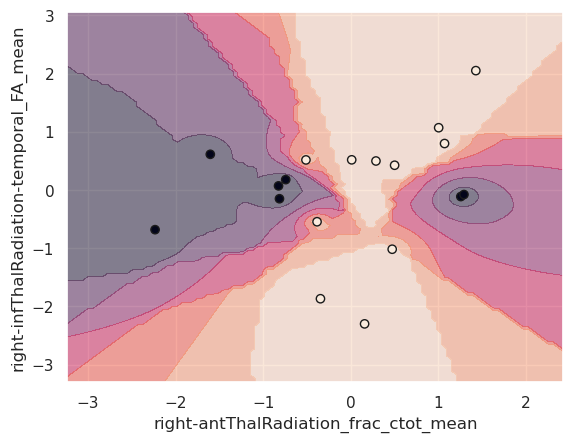

In [34]:
from sklearn.inspection import DecisionBoundaryDisplay

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['right-antThalRadiation_frac_ctot_mean', 'right-infThalRadiation-temporal_FA_mean']])

knn = KNeighborsClassifier(
        n_neighbors=4,
        weights="distance",
        n_jobs=-1
    )

knn.fit(X_scaled, y)

disp = DecisionBoundaryDisplay.from_estimator(
    knn,
    X_scaled,
    response_method="predict_proba",
    xlabel='right-antThalRadiation_frac_ctot_mean',
    ylabel='right-infThalRadiation-temporal_FA_mean',
    alpha=0.5,
    plot_method="contourf"
)
disp.ax_.scatter(
    X_scaled[:, 0],
    X_scaled[:, 1],
    c=y,
    edgecolors="k"
)
plt.show()

# Decision tree

#### Scaling pruning

In [4]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, PowerTransformer
from sklearn.model_selection import StratifiedShuffleSplit

for scaler in [StandardScaler(), MinMaxScaler(), Normalizer("l1"), Normalizer("l2"), RobustScaler()]:
    print(scaler.__class__.__name__)
    
    run_tree_cv(
        X, 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=scaler,
        )

StandardScaler
F1: 0.396 | Pr: 0.705 | Re: 0.985 | AUC: 0.557 | Accuracy: 0.450 

MinMaxScaler
F1: 0.396 | Pr: 0.705 | Re: 0.985 | AUC: 0.557 | Accuracy: 0.450 

Normalizer
F1: 0.465 | Pr: 0.676 | Re: 0.996 | AUC: 0.487 | Accuracy: 0.462 

Normalizer
F1: 0.466 | Pr: 0.682 | Re: 0.994 | AUC: 0.482 | Accuracy: 0.455 

RobustScaler
F1: 0.396 | Pr: 0.705 | Re: 0.985 | AUC: 0.557 | Accuracy: 0.450 



#### Hyperparam Tuning

In [14]:
# Hyper-parameters pruning
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

param_grid = {
    "decisiontreeclassifier__criterion" : ['gini', 'entropy', 'log_loss'],
    "decisiontreeclassifier__max_depth" : [2, 3, 5, 7, 11, 13, 19],
}

pipe = make_pipeline(
    StandardScaler(), 
    DecisionTreeClassifier(
        splitter="best",
        max_features=None,
        random_state=7,
        class_weight="balanced",
    )
)

gridSearch = GridSearchCV(
    pipe,
    param_grid,
    scoring=make_scorer(auc_and_f1, needs_proba=True),
    n_jobs=-1,
    cv=StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
)

gridSearch.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1000, random_state=7,
            test_size=0.3333333333333333, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               random_state=7))]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy',
                                                               'log_loss'],
                         'decisiontreeclassifier__max_depth': [2, 3, 5, 7, 11,
                                                               13, 19]},
             scoring=make_scorer(auc_and_f1, needs_proba=True))

In [15]:
print("f1 + auc score")
print(gridSearch.cv_results_["mean_test_score"])
print(gridSearch.cv_results_["std_test_score"])
print(gridSearch.cv_results_["rank_test_score"])

f1 + auc score
[0.95223452 0.95223452 0.95223452 0.95223452 0.95223452 0.95223452
 0.95223452 0.94223095 0.94223095 0.94223095 0.94223095 0.94223095
 0.94223095 0.94223095 0.94223095 0.94223095 0.94223095 0.94223095
 0.94223095 0.94223095 0.94223095]
[0.30438547 0.30438547 0.30438547 0.30438547 0.30438547 0.30438547
 0.30438547 0.30302561 0.30302561 0.30302561 0.30302561 0.30302561
 0.30302561 0.30302561 0.30302561 0.30302561 0.30302561 0.30302561
 0.30302561 0.30302561 0.30302561]
[1 1 1 1 1 1 1 8 8 8 8 8 8 8 8 8 8 8 8 8 8]


In [ ]:
"""
f1 + auc score
[0.95223452 0.95223452 0.95223452 0.95223452 0.95223452 0.95223452
 0.95223452 0.94223095 0.94223095 0.94223095 0.94223095 0.94223095
 0.94223095 0.94223095 0.94223095 0.94223095 0.94223095 0.94223095
 0.94223095 0.94223095 0.94223095]
[0.30438547 0.30438547 0.30438547 0.30438547 0.30438547 0.30438547
 0.30438547 0.30302561 0.30302561 0.30302561 0.30302561 0.30302561
 0.30302561 0.30302561 0.30302561 0.30302561 0.30302561 0.30302561
 0.30302561 0.30302561 0.30302561]
[1 1 1 1 1 1 1 8 8 8 8 8 8 8 8 8 8 8 8 8 8]

gini 10
"""

#### Sequential Feature Selection

Here launch the feature selection in seqFeatureSelec.py with the tuned parameters.

Check the performance with the selected features

In [35]:
run_tree_cv(
    X[['lh.cbd_fvf_tot_mean', 'right-hippocampus_frac_ctot_mean']], 
    y,
    StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
    pipeline=scaler,
    max_depth=10,
)

F1: 0.467 | Pr: 0.727 | Re: 0.968 | AUC: 0.653 | Accuracy: 0.521 



DecisionTreeClassifier(class_weight='balanced', max_depth=10, random_state=7)

#### Dispaly decision boundary

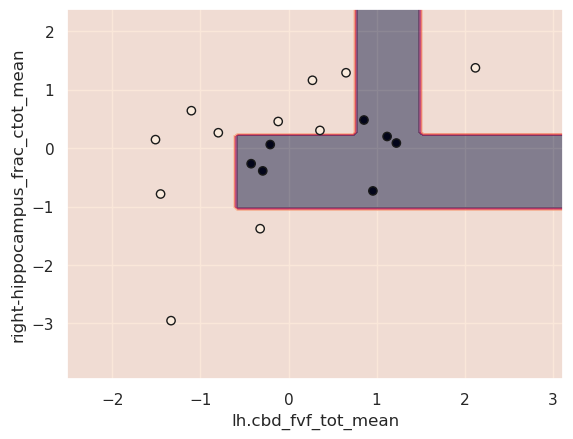

In [36]:
from sklearn.inspection import DecisionBoundaryDisplay

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['lh.cbd_fvf_tot_mean', 'right-hippocampus_frac_ctot_mean']])

tree = DecisionTreeClassifier(
    criterion="gini",
    splitter="best",
    max_depth=10,
    max_features=None,
    random_state=7,
    class_weight="balanced",
)

tree.fit(X_scaled, y)

disp = DecisionBoundaryDisplay.from_estimator(
    tree,
    X_scaled,
    response_method="predict_proba",
    xlabel='lh.cbd_fvf_tot_mean',
    ylabel='right-hippocampus_frac_ctot_mean',
    alpha=0.5,
    plot_method="contourf"
)
disp.ax_.scatter(
    X_scaled[:, 0],
    X_scaled[:, 1],
    c=y,
    edgecolors="k"
)
plt.show()